# Spettro del Rubino

In [1]:
import sys
print(sys.executable)
import scipy
import numpy

/Applications/Anaconda/anaconda3/bin/python


In [2]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from modules import utils
import pandas as pd
import ast
import scipy as sp
from matplotlib import cm

plt.close('all')

/Users/elena/Desktop/Lab_Materia_Condensata/modules/utils.py:132: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ser = pd.Series()
/Users/elena/Desktop/Lab_Materia_Condensata/modules/utils.py:132: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ser = pd.Series()
/Users/elena/Desktop/Lab_Materia_Condensata/modules/utils.py:132: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ser = pd.Series()
/Users/elena/Desktop/Lab_Materia_Condensata/modules/utils.py:132: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ser = pd.Series()
/Users/elena

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,6901.060059,7000.0,1.008301,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6880.602539,7000.0,0.602539,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7002.104980,7300.0,1.504395,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7303.045410,7500.0,1.247559,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6890.741699,7050.0,0.643066,249
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,6890.643066,7050.0,0.641113,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,6890.416992,7015.0,0.419434,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,7000.602539,7180.0,0.600586,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,6890.716309,7015.0,0.417480,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,6951.498535,7100.0,0.498535,299


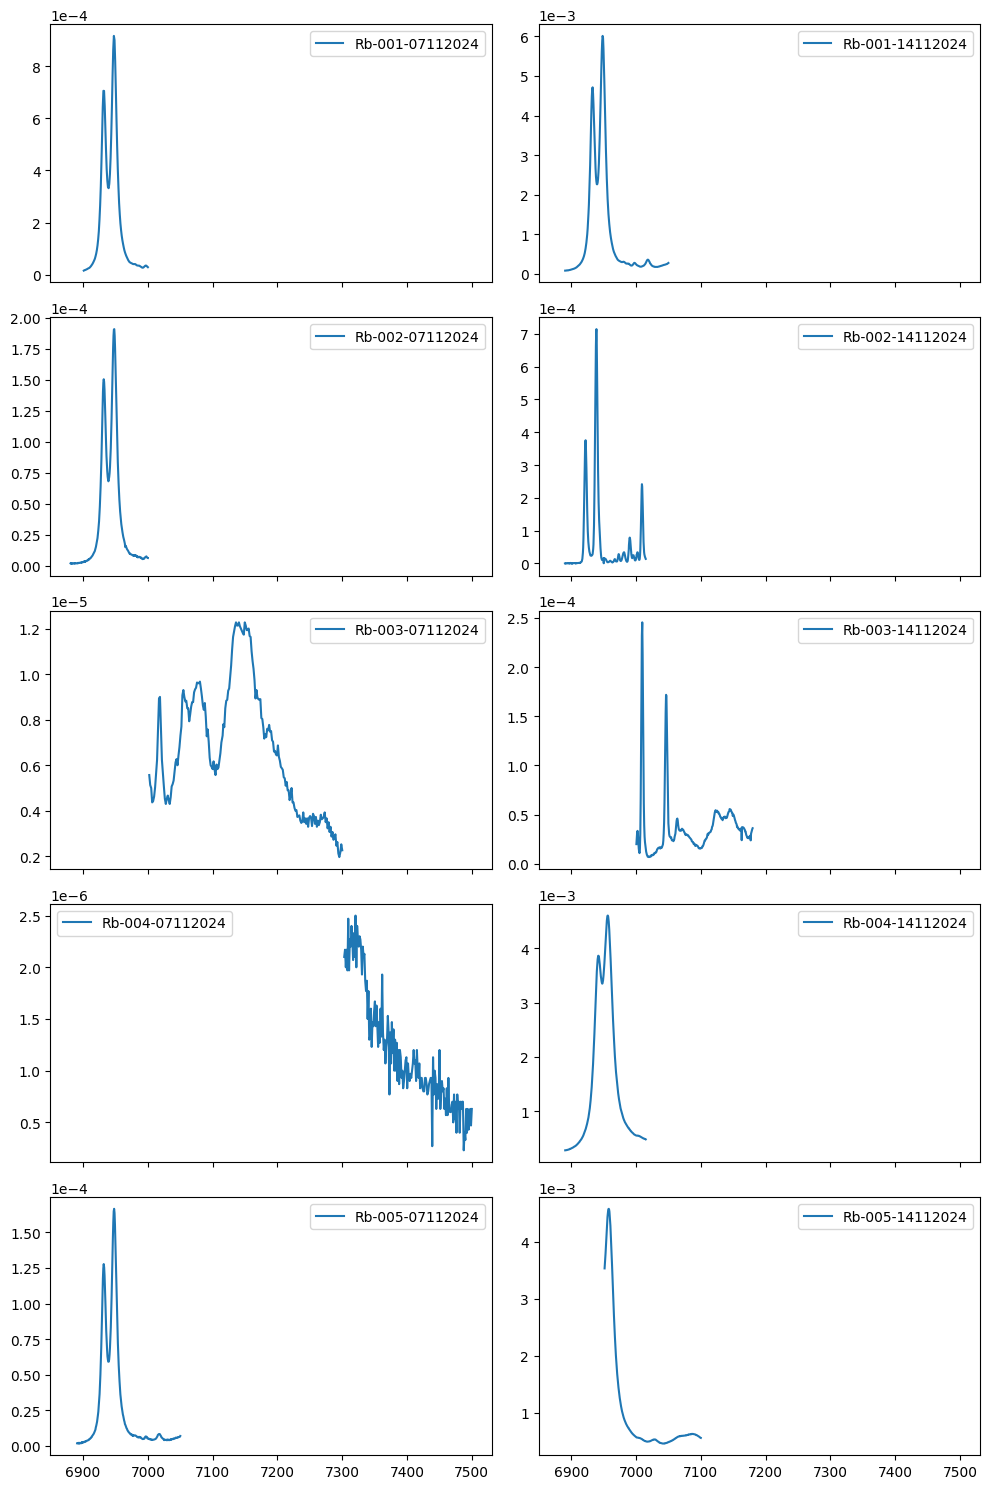

In [3]:
files = utils.getFiles('Raw_Data/Rubidium_Spectrum')
files = [file for file in files if file.name.find('Rb_') != -1]
df = pd.DataFrame([utils.file_to_series(file) for file in files])

# sort it
df.sort_values('id', inplace=True)
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

# A quick look at the batch
fig, axs = plt.subplots(5, 2, sharex=True, figsize=(10, 15), layout='tight')
for i, row in df.iterrows():
    meta = ast.literal_eval(row['meta'])
    label = "-".join([meta.get(key) for key in ['type', 'id', 'date',]])
    axs[ i % 5, int(i / 5)].plot(row['wl'], row['mean'], label=label)
    
for ax in axs.flat:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) 
    ax.legend()
    
# generate the info table
info = df['meta'].apply(ast.literal_eval).apply(pd.Series)
info = info[['type', 'id', 'date'] + [col for col in info.columns if col not in ['type', 'id', 'date']]]
info['start'] = df['wl'].apply(lambda x: x[0])
info['stop'] = df['wl'].apply(lambda x: x[-1])
info['step'] = df['wl'].apply(lambda x: x[1] - x[0])
info['samples'] = df['wl'].apply(len)

info

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
0,Rb,001,07112024,300ms,450V,2tac,2tac,307Hz,NaN,6901.060059,7000.0,1.008301,99
1,Rb,002,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6880.602539,7000.0,0.602539,199
2,Rb,003,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7002.104980,7300.0,1.504395,199
3,Rb,004,07112024,300ms,450V,1tac,1tac,307Hz,NaN,7303.045410,7500.0,1.247559,159
4,Rb,005,07112024,300ms,450V,1tac,1tac,307Hz,NaN,6890.741699,7050.0,0.643066,249


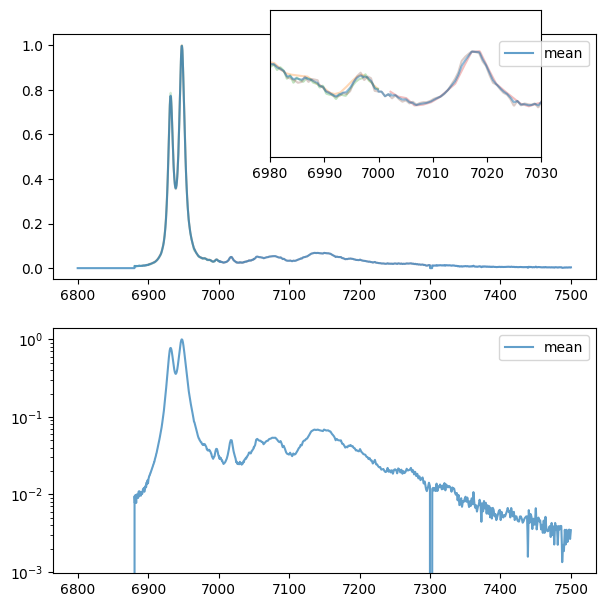

In [4]:
from scipy.interpolate import interp1d

def mean_overlap(comm_wl : np.ndarray, batch : pd.DataFrame):
    ''' 
    This function computes the mean of varius slices of
    batch over an interval
    '''
    
    # this is the result
    mean = np.zeros(len(comm_wl))
    
    # this counts the number of samples 
    # in each wl
    counts = np.zeros(len(comm_wl))
    
    for i, row in batch.iterrows():
        wl = row['int_wl']
        y = row['int_mean']
        min = np.argmax(comm_wl >= wl.min())
        max = np.argmax(comm_wl > wl.max())
        
        # if the max is 0, it means that the wl is larger than the maximum
        if max == 0:
            max = len(comm_wl)

        mean[min:max]  =  mean[min:max] + y
        counts[min:max] = counts[min:max] + 1
    
    mean = np.divide(mean, counts, out=np.zeros_like(mean), where=counts!=0)
    return mean

def myinterp(series, x_new):
    # extract the x and y values
    x = series['wl']
    y = series['mean']
    
    # keep only the values that are within the range
    mask = np.logical_and(x_new > x.min(), x_new < x.max())
    x_new = x_new[mask]
    
    # return both the new x and the interpolated values
    f = interp1d(x, y, kind='linear')
    return x_new, f(x_new)

def interpolate_batch(batch, common_wl):
    ''' 
    If normalization is not given divide by the maximum value
    '''    
    # interpolate the batch
    batch['interp'] = batch.apply(myinterp, x_new = common_wl, axis=1).to_numpy()
    batch['int_wl'] = batch['interp'].apply(lambda x: x[0])
    batch['int_mean'] = batch['interp'].apply(lambda x: x[1])

    common_mean = mean_overlap(common_wl, batch)
    return common_mean

def plot_interp_batch(batch, common_wl, common_mean):
    fig, axs = plt.subplots(2, 1, figsize=(7, 7))
    # inset 
    inset = axs[0].inset_axes([0.4, 0.5, 0.5, 0.6])
    inset.set_xlim(6980, 7030)
    inset.set_ylim(0, .07)
    inset.set(yticks=[])
    
    # plot the mean
    axs[0].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    inset.plot(common_wl, common_mean, label='mean', alpha = 0.5, zorder = 2)

    # plot the interpolated batch
    batch['interp'].apply(lambda x: axs[0].plot(x[0], x[1], alpha=0.2, zorder = 1))
    batch['interp'].apply(lambda x: inset.plot(x[0], x[1], alpha=0.3, zorder = 1))

    # plot a clean result in log scale
    axs[1].plot(common_wl, common_mean, label='mean', alpha = 0.7, zorder = 2)
    axs[1].set_yscale('log')

    for ax in axs.flat:
        ax.legend()  
    return axs

def normalize(series : pd.Series , ids : list, norm = None):
    if not (series['id'] in ids):
        return series
    
    if norm is None:
        norm = series['mean'].max()
   
    series['mean'] = series['mean'] / norm
    return series

# @ room temperature
mask = df['date'] == '07112024' 
batch_0 = df[mask]
display(info[mask])
  
batch_0 = batch_0.apply(normalize, ids = ['001', '002', '005'] ,  axis=1)
batch_0 = batch_0.apply(normalize, ids = ['003', '004'] ,  axis=1, norm = 0.000179)

common_wl = np.arange(6800, 7500, 0.1)
common_mean = interpolate_batch(batch_0, common_wl)

axs = plot_interp_batch(batch_0, common_wl, common_mean)

,type,id,date,integration time,PT tension,output slit,input slit,lock freq,temp,start,stop,step,samples
5,Rb,001,14112024,300ms,700V,2tac,2tac,307Hz,300K,6890.643066,7050.0,0.641113,249
6,Rb,002,14112024,300ms,700V,2tac,2tac,307Hz,77K,6890.416992,7015.0,0.419434,299
7,Rb,003,14112024,300ms,700V,2tac,2tac,307Hz,77K,7000.602539,7180.0,0.600586,299
8,Rb,004,14112024,300ms,700V,2tac,2tac,307Hz,4p7-5mV,6890.716309,7015.0,0.417480,299
9,Rb,005,14112024,300ms,700V,2tac,2tac,307Hz,5mV,6951.498535,7100.0,0.498535,299


/var/folders/r6/dy_fwrh50c1_mkbs1c66wqmm0000gn/T/ipykernel_17419/1568856668.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp'] = info.loc[mask, 'temp'].values
/var/folders/r6/dy_fwrh50c1_mkbs1c66wqmm0000gn/T/ipykernel_17419/1568856668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
/var/folders/r6/dy_fwrh50c1_mkbs1c66wqmm0000gn/T/ipykernel_17419/1568856668.py:10: SettingWithCopyWarning: 
A value is trying to be set on a cop

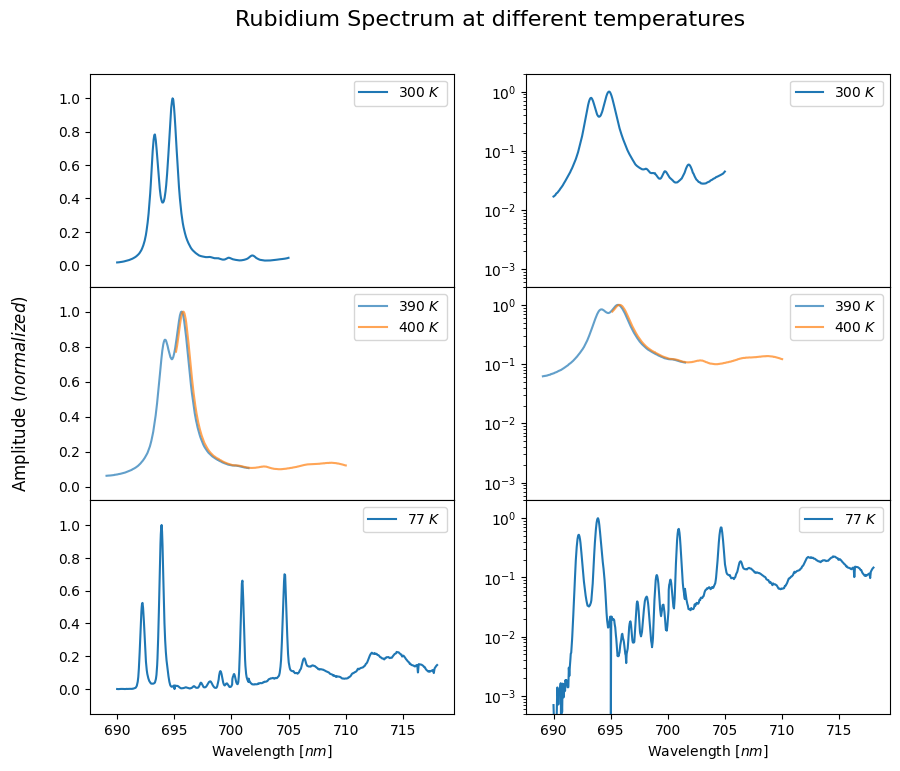

In [5]:
mask = df['date'] == '14112024' 
batch_0 = df[mask]
display(info[mask])

# add the temperature
batch_0['temp'] = info.loc[mask, 'temp'].values

# HACk
batch_0['temp_groups'] = ['300K', '77K', '77K', '400K', '400K']
batch_0['temp'] = ['300K', '77K', '77K', '390K', '400K']
ids = ['001', '002', '003', '004', '005']

common_wl = np.arange(6900, 7200, 0.1)

fig, axs = plt.subplots(3, 2, figsize=(10, 8), sharex=True)
i = 0
for gid, group in batch_0.groupby('temp_groups'):

    # normalize the group
    group = group.apply(normalize, axis=1, ids = ids)

    # interpolate the group    
    if gid == '400K':
        group.apply(lambda x: axs[i, 0].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                             label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
        group.apply(lambda x: axs[i, 1].plot(x['wl'] / 10, x['mean'], alpha=0.7, 
                                             label = r'${}\ K$'.format(x['temp'][:-1])), axis=1)
    else:
        label = r'${}\ K$'.format(gid[:-1])
        common_mean = interpolate_batch(group, common_wl)
        # plot
        mask = common_mean > 0
        axs[i, 0].plot(common_wl[mask] / 10, common_mean[mask], label=label)
        axs[i, 1].plot(common_wl[mask] / 10, common_mean[mask], label=label)
        
    axs[i, 0].margins(y=0.15)
    axs[i, 1].set_ylim(5e-4, 2)
    axs[i, 1].set_yticks([1e-3, 1e-2, 1e-1, 1])
    axs[i, 1].margins(y=0.15)
    axs[i, 1].set_yscale('log')
    i = i + 1

fig.subplots_adjust(hspace=0, left=0.1, right=0.9, top=0.9, bottom=0.1)
fig.supylabel('Amplitude $(normalized)$')
fig.suptitle('Rubidium Spectrum at different temperatures', fontsize=16)

# common_mean = interpolate_batch(batch_0, common_wl)
for ax in axs.flat:
    ax.set_xlabel('Wavelength $[nm]$')
    ax.legend()

In [6]:
figures = {num: plt.figure(num) for num in plt.get_fignums()}
print(figures)

{}


In [7]:
from ipywidgets import FloatRangeSlider, FloatLogSlider, AppLayout, interactive, VBox, Output


cm = plt.get_cmap('tab10')
with plt.ioff():
    fig, ax = plt.subplots(figsize=(8, 5))    
    

def find_peaks(prominence=6e-7, width=(1, 20)):
    '''This function will be turned into a widget'''
    ax.clear()
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.set_yscale('log')
    
    label = 'mean'
    ax.plot(comm_wl, comm_mean, label=label)
    step = comm_wl[1] - comm_wl[0]
    width = (width[0] / step, width[1] / step)
    peaks, properties = sp.signal.find_peaks(comm_mean, prominence=prominence, width=width)
    if len(peaks) == 0:
        return

    res_full = sp.signal.peak_widths(comm_mean, peaks, rel_height=.5)
    # HACK: for some reason res_full[1:] is treathed as a tuple
    y, xmin, xmax = res_full[1:]
    
    # resize the values to data space
    step = comm_wl[1] - comm_wl[0]
    xmin = comm_wl[0] + step * xmin
    xmax = comm_wl[0] + step * xmax
        
    # add the peaks to the results
    results = peaks

    # draw the peaks
    ax.plot(comm_wl[peaks], comm_mean[peaks], "x", alpha=0.5)
    ax.vlines(x=comm_wl[peaks], ymin=comm_mean[peaks] - properties["prominences"],
                    ymax = comm_mean[peaks], alpha=0.5)  
    ax.hlines(y=y, xmin=xmin, xmax=xmax, alpha=0.5)
    
    ax.legend()
    return results


# widget to find peaks
prominance = FloatLogSlider(value=1.22e-6, base=10, min=-8, max=1, step=0.01, readout_format='.3e', continuous_update=False)
width = FloatRangeSlider(value=(1, 20), min=0, max=50, step=.1, readout_format='.1f', continuous_update=False)
w = interactive(find_peaks, prominence=prominance, width=width, continuous_update=False)
out = Output()
result = Output()
with out:
    display(info)
with result:
    display(w.result)

AppLayout(
    center=fig.canvas,
    right_sidebar=VBox([w, result]),
    footer = out,
    pane_widths=[0, 2, 1]
)

TraitError: The 'center' trait of an AppLayout instance expected a Widget or None, not the FigureCanvasAgg at '0x7fdaf50a85b0'.

# Fit dei picchi del Rubino con Voight - parte fatta da Sof

### Pacchetti necessari

In [75]:
from lmfit import Minimizer, create_params, report_fit, Model
from lmfit.lineshapes import gaussian, lorentzian, voigt
from scipy.stats import linregress
from pprint import pprint
from matplotlib.patches import Rectangle


### Importo dati

In [72]:
data_hot = df[(df["date"] == "14112024") & (df["id"] == "004")]
wl_hot = data_hot["wl"].values[0]
sign_hot = data_hot["mean"].values[0]

data_cold = df[(df["date"] == "14112024") & (df["id"] == "002")]
wl_cold = data_cold["wl"].values[0]
sign_cold = data_cold["mean"].values[0]

data_RT = df[(df["date"] == "14112024") & (df["id"] == "001")]
wl_RT = data_RT["wl"].values[0]
sign_RT = data_RT["mean"].values[0]


### Plotto dati raw

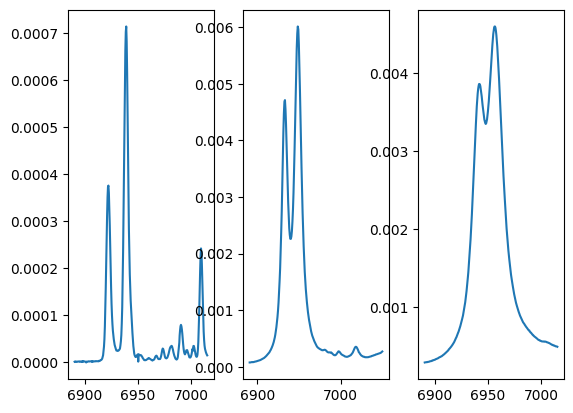

In [74]:
fig, axs = plt.subplots(1,3)
axs[0].plot(wl_cold,sign_cold)
axs[1].plot(wl_RT,sign_RT)
axs[2].plot(wl_hot,sign_hot)

### Fit curva cold

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

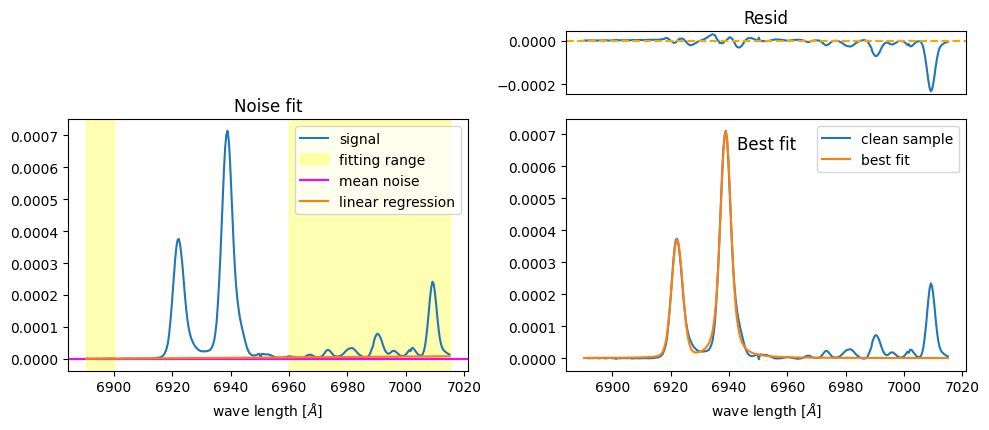

In [65]:
pfit = create_params(amp_1 = 0.0082342, cen_1 = 6922, sig_1 = 5, gamma_1 = 0.05,
                     amp_2 = 0.02, cen_2 = 6939, sig_2 = 5, gamma_2 = 0.9,
                     y0 = 2.03e-6)
# pfit['y0'].set(vary=False)
# pfit['cen_1'].set(value = 8185.46, vary=False)
# pfit['cen_2'].set(value = 8196.06, vary=False)

# fit the noise
noise_edgs = {'below' : 6900,
              'above' : 6960}

noise_mask = (wl_cold < noise_edgs['below']) | (wl_cold > noise_edgs['above'])
noise_mask = (noise_mask) & (wl_cold < 6960) 
print(noise_mask)
res = linregress(wl_cold[noise_mask], sign_cold[noise_mask])
print('mean noise :', np.mean(sign_cold[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = sign_cold - np.polyval(res[:2], wl_cold)


mini = Minimizer(residual , pfit, fcn_args=(wl_cold, clean_sample))
out = mini.leastsq()
best_fit = clean_sample + out.residual
report_fit(out.params)

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()
axs[0].set_title('Noise fit')
#axs[0].set(ylim=(-8e-6, -4e-6))

# noise fit
axs[0].plot(wl_cold, sign_cold, label='signal')
axs[0].axvspan(wl_cold.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(sign_cold[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl_cold.max(), color='yellow', alpha=0.3)
axs[0].plot(wl_cold, np.polyval(res[:2], wl_cold), label = 'linear regression')

# clean sample
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl_cold, clean_sample, label='clean sample')
axs[1].plot(wl_cold, best_fit, label='best fit')
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl_cold, out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[\AA]$')
    
fig.tight_layout()

### Fit curva RT

In [109]:
pfit = create_params(amp_1 = 0.0082342, cen_1 = 6925, sig_1 = 3, gamma_1 = 0.005,
                     amp_2 = 0.02, cen_2 = 6955, sig_2 = 7, gamma_2 = 0.03,
                     y0 = 2.03e-6)
# pfit['y0'].set(vary=False)
# pfit['cen_1'].set(value = 8185.46, vary=False)
# pfit['cen_2'].set(value = 8196.06, vary=False)

# fit the noise
noise_edgs = {'below' : 6910,
              'above' : 6975}

noise_mask = (wl_RT < noise_edgs['below']) | (wl_RT > noise_edgs['above'])
res = linregress(wl_RT[noise_mask], sign_RT[noise_mask])
print('mean noise :', np.mean(sign_RT[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = sign_RT - np.polyval(res[:2], wl_RT)

mini = Minimizer(residual , pfit, fcn_args=(wl_RT, clean_sample))
out = mini.leastsq()
best_fit = clean_sample + out.residual
report_fit(out.params)

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()
axs[0].set_title('Noise fit')
#axs[0].set(ylim=(-8e-6, -4e-6))

# noise fit
axs[0].plot(wl_RT, sign_RT, label='signal')
axs[0].axvspan(wl_RT.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(sign_RT[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl_RT.max(), color='yellow', alpha=0.3)
axs[0].plot(wl_RT, np.polyval(res[:2], wl_RT), label = 'linear regression')

# clean sample
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl_RT, clean_sample, label='clean sample')
axs[1].plot(wl_RT, best_fit, label='best fit')
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl_RT, out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[\AA]$')
    
fig.tight_layout()

mean noise : 0.00020599329
LinregressResult(slope=7.986713403591292e-07, intercept=-0.005376065000433037, rvalue=0.5994889695202638, pvalue=8.27262228998027e-16, stderr=8.824870506869505e-08, intercept_stderr=0.0006168017559814423)


KeyError: 'x01'

### Fit curva hot

In [ ]:
da inserire

### Fit alternativo, curva RT

mean noise : 0.0001831296
LinregressResult(slope=1.6304642032427295e-06, intercept=-0.011149965155757115, rvalue=0.9468128848944409, pvalue=2.871170432089554e-27, stderr=7.684414101837098e-08, intercept_stderr=0.0005341430028620327)
[[Variables]]
    x01:      6932.74724 +/- 0.02588509 (0.00%) (init = 6932)
    width1:   0.30503961 +/- 0.01299227 (4.26%) (init = 0.4)
    height1:  0.00778911 +/- 4.1668e-04 (5.35%) (init = 0.01)
    shape1:   0.70175763 +/- 0.06664172 (9.50%) (init = 1.23)
    x02:      6948.64832 +/- 0.02198977 (0.00%) (init = 6948.7)
    width2:   0.38893446 +/- 0.02118466 (5.45%) (init = 0.73)
    height2:  0.01800526 +/- 0.00107933 (5.99%) (init = 0.036)
    shape2:   1.55213502 +/- 0.11712202 (7.55%) (init = 3.34)
[[Correlations]] (unreported correlations are < 0.100)
    C(height2, shape2)  = +0.9976
    C(width2, height2)  = +0.9941
    C(height1, shape1)  = +0.9936
    C(width2, shape2)   = +0.9922
    C(width1, height1)  = +0.9820
    C(width1, shape1)   = +0.9

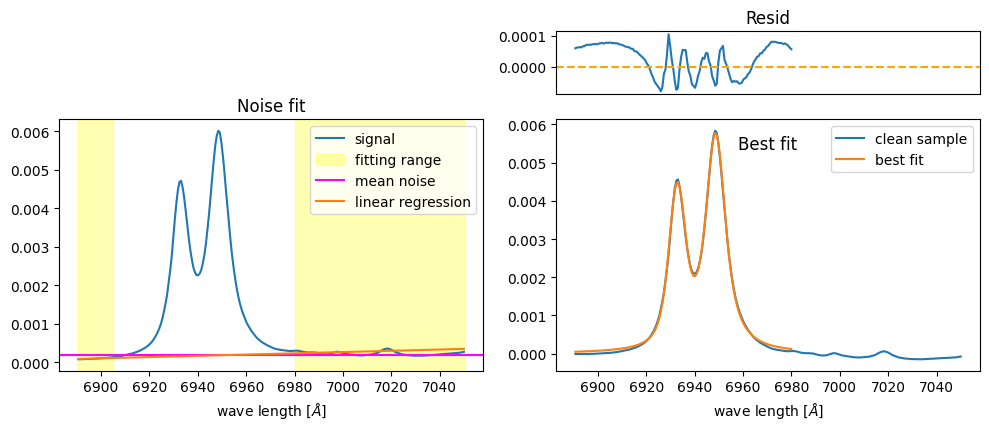

In [114]:
from scipy.special import wofz
# IGOR VOIGT FUNCTION WRAPPING
# from CHATGPT but checked for correctness
def voigt_func(x, shape_factor):
    """
    Computes the Voigt function as the real part of the Faddeeva function.
    :param x: Input wave (numpy array)
    :param shape_factor: Determines the Gaussian-Lorentzian mix.
    :return: Voigt peak values.
    """
    return np.real(wofz(x + 1j * shape_factor))

def mpfx_voigt_peak(x,x0, width, height,shape):
    """
    Computes a Voigt peak function and fills yw with computed values.
    :param cw: Coefficient wave (array-like of length 4)
               cw[0]: Peak location
               cw[1]: Width-affecting factor
               cw[2]: Amplitude factor
               cw[3]: Shape factor (0 = Gaussian, Inf = Lorentzian, sqrt(ln(2)) = 50/50)
    :param xw: X values where the function is evaluated
    :return: 0 if successful, NaN if input is invalid
    """
    return height * voigt_func(width * (x - x0), shape)


def residual(pars, x, data):
    x01 = pars['x01']
    width1 = pars['width1']
    height1 = pars['height1']
    shape1 = pars['shape1']
    x02 = pars['x02']
    width2 = pars['width2']
    height2 = pars['height2']
    shape2 = pars['shape2']
    vmodel =  mpfx_voigt_peak(x,x01, width1, height1,shape1) + mpfx_voigt_peak(x,x02, width2, height2,shape2)
    return vmodel - data
    
# Parametri iniziali per il fit
pfit = create_params(x01=6932, width1=0.4, height1=0.01,shape1=1.23,
                     x02= 6948.7, width2=0.73, height2=0.036,shape2=3.34)
# fit the noise
noise_edgs = {'below' : 6905,
              'above' : 6980}

noise_mask = (wl_RT < noise_edgs['below']) | (wl_RT> noise_edgs['above'])
noise_mask=(noise_mask) & (wl_RT < 7000)
res = linregress(wl_RT[noise_mask], sign_RT[noise_mask])
print('mean noise :', np.mean(sign_RT[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = sign_RT - np.polyval(res[:2], wl_RT)

fitting_mask = (wl_RT < 6980)

mini = Minimizer(residual , pfit, fcn_args=(wl_RT[fitting_mask], clean_sample[fitting_mask]))
out = mini.leastsq()
best_fit = clean_sample[fitting_mask] + out.residual
report_fit(out.params)

fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()

axs[0].set_title('Noise fit')


# noise fit
axs[0].plot(wl_RT, sign_RT, label='signal')
axs[0].axvspan(wl_RT.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(sign_RT[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl_RT.max(), color='yellow', alpha=0.3)
axs[0].plot(wl_RT, np.polyval(res[:2], wl_RT), label = 'linear regression')

# clean sample
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl_RT, clean_sample, label='clean sample')
axs[1].plot(wl_RT[fitting_mask], best_fit, label='best fit')
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl_RT[fitting_mask], out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[\AA]$')
    
fig.tight_layout()

# TEST

In [ ]:
import numpy as np
import pandas as pd
import scipy.special as sp
import scipy.optimize as opt
import matplotlib.pyplot as plt

def voigt_function(x, y0, Area, WG, x0, Shape):
    sqrt_ln2 = np.sqrt(np.log(2))
    prefactor = (2 * Area / WG) * np.sqrt(np.log(2) / np.pi)
    arg1 = (2 * sqrt_ln2 / WG) * (x - x0)
    arg2 = Shape * 2 * sqrt_ln2
    return y0 + prefactor * sp.wofz(arg1 + 1j * arg2).real

def double_voigt(x, y0, Area1, WG1, x01, Shape1, Area2, WG2, x02, Shape2):
    res = voigt_function(x, y0, Area1, WG1, x01, Shape1) + voigt_function(x, y0, Area2, WG2, x02, Shape2)
    return res

fig, ax = plt.subplots()
ax.plot(wl_hot,double_voigt(wl_hot, ))

# Fit dei dati con la funzione double_voigt
def fit_double_voigt(x_data, y_data):
    model = double_voigt
    
    # Parametri iniziali per il fit
    pfit = create_params(y0 = 2.3e-6, area1 = 0.0082342, WG1= 3, x01 = 6941, shape1 = 3, area2 = 0.005,
                     WG2 = 0.02, x02 = 6957, shape2 = 7)

    # Esegui il fit
    result = model.fit(y_data, params, x=x_data)
    return result


fig, ax = plt.subplots()
ax.plot(wl_hot,fit_double_voigt(wl_hot,sign_hot))